Repetimos los pasos del analisis anterior para llegar al bag of words preprocesadas y la separación train-test

Importamos las herramientas/utils a utilizar

In [ ]:
import unicodedata
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
import unicodedata
from nltk.corpus import stopwords
import pandas as pd
from nltk.stem import PorterStemmer  # Importar la clase PorterStemmer
import random
import numpy as np
import pandas as pd
from collections import Counter # Exploración
from nltk import ngrams # Exploración
from nltk.probability import FreqDist # Exploración
import unicodedata # Preprocesado
import re # Preprocesado
import random
import numpy as np
import pandas as pd
from collections import Counter # Exploración
from nltk import ngrams # Exploración
from nltk.probability import FreqDist # Exploración
import unicodedata # Preprocesado
import re # Preprocesado
from sklearn.model_selection import train_test_split # Modelado
from sklearn.pipeline import Pipeline # Modelado
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer # Modelado
from sklearn.feature_selection import chi2 # Reporte
from sklearn.linear_model import LogisticRegression # Reporte
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, precision_recall_curve # Reporte
import matplotlib.pyplot as plt
import gzip
import json
import pandas as pd
import urllib.request
import random
import numpy as np
import pandas as pd
from collections import Counter # Exploración
from nltk import ngrams # Exploración
from nltk.probability import FreqDist # Exploración
import unicodedata # Preprocesado
import re # Preprocesado
from sklearn.model_selection import train_test_split # Modelado
from sklearn.pipeline import Pipeline # Modelado
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer # Modelado
from sklearn.feature_selection import chi2 # Reporte
from sklearn.linear_model import LogisticRegression # Reporte
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, precision_recall_curve # Reporte
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

Repetimos la bajada de datos

In [ ]:
! wget http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Toys_and_Games_5.json.gz

--2024-03-23 18:35:04--  http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Toys_and_Games_5.json.gz
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42057555 (40M) [application/x-gzip]
Saving to: ‘reviews_Toys_and_Games_5.json.gz.1’

reviews_Toys_and_Ga 100%[===================>]  40.11M  10.9MB/s    in 5.3s    

2024-03-23 18:35:09 (7.54 MB/s) - ‘reviews_Toys_and_Games_5.json.gz.1’ saved [42057555/42057555]



In [ ]:

url = 'http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Toys_and_Games_5.json.gz'
urllib.request.urlretrieve(url, 'reviews_Toys_and_Games_5.json.gz')

('reviews_Toys_and_Games_5.json.gz',
 <http.client.HTTPMessage at 0x7a9fb017d390>)

Y los convertimos en una lista de diccionarios.

In [ ]:
# Lista para almacenar los datos
data = []

# Abre el archivo JSON comprimido y descomprímelo
with gzip.open('reviews_Toys_and_Games_5.json.gz', 'rt', encoding='utf-8') as f:
    # Lee cada línea del archivo
    for line in f:
        # Carga el contenido de la línea en un diccionario
        item = json.loads(line)
        # Agrega el diccionario a la lista de datos
        data.append(item)

# Ahora puedes trabajar con los datos, que estarán en forma de una lista de diccionarios. Los pasamos a un dataframe
df = pd.DataFrame(data)

Veamos la estructura de los datos

In [ ]:
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A1VXOAVRGKGEAK,0439893577,Angie,"[0, 0]",I like the item pricing. My granddaughter want...,5.0,Magnetic board,1390953600,"01 29, 2014"
1,A8R62G708TSCM,0439893577,Candace,"[1, 1]",Love the magnet easel... great for moving to d...,4.0,it works pretty good for moving to different a...,1395964800,"03 28, 2014"
2,A21KH420DK0ICA,0439893577,capemaychristy,"[1, 1]",Both sides are magnetic. A real plus when you...,5.0,love this!,1359331200,"01 28, 2013"
3,AR29QK6HPFYZ4,0439893577,dcrm,"[0, 0]",Bought one a few years ago for my daughter and...,5.0,Daughters love it,1391817600,"02 8, 2014"
4,ACCH8EOML6FN5,0439893577,DoyZ,"[1, 1]",I have a stainless steel refrigerator therefor...,4.0,Great to have so he can play with his alphabet...,1399248000,"05 5, 2014"


In [ ]:
df.columns

Index(['reviewerID', 'asin', 'reviewerName', 'helpful', 'reviewText',
       'overall', 'summary', 'unixReviewTime', 'reviewTime'],
      dtype='object')

Procedemos a definir la función de normalización y limpieza, que pasará las palabras a minusculas, creará tokens por palabras, eliminará los caracteres especiales, quitará las stopwords, eliminará palabras que son muy comunes pero no aportan (item, pricing) y aplicará un stemming para poder utilizar terminos normalizados en los modelos predictivos.

In [ ]:

# Crear una instancia de PorterStemmer
stemmer = PorterStemmer()

# Definir la función de normalización
def normalizacion(review):
    # Separar la revisión en palabras
    review = review.split()
    # Convertir todas las palabras a minúsculas
    review = [word.lower() for word in review]
    # Quitar espacios en blanco al inicio y al final de la revisión
    review = [word.strip() for word in review]
    # Normalizar caracteres especiales
    review = [unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore') for word in review]
    # Obtener lista de palabras vacías en inglés
    sw_list = set(stopwords.words('english'))
    # Eliminar palabras vacías de la revisión
    review = [word for word in review if word not in sw_list]
    # Eliminar letras huecas (necesario para que el ejercicio de n-gram tenga sentido)
    review = [word for word in review if word not in [',', '.', "'"]]
    # Eliminar las palabras 'pricing' y 'item' del texto
    review = [word for word in review if word not in ['pricing', 'item']]
    # Aplicar stemming a cada palabra
    review = [stemmer.stem(word) for word in review]
    # Unir las palabras en una cadena de texto
    review = ' '.join(review)
    return review

# Aplicar la función de normalización a la columna 'reviewText'
df['reviewText_norm'] = df['reviewText'].apply(normalizacion)

# Imprimir el DataFrame con la columna normalizada
print(df['reviewText_norm'].head())



0    like pricing. granddaught want mark want letters.
1    love magnet easel... great move differ areas.....
2    side magnetic. real plu entertain one child. f...
3    bought one year ago daughter love it, still us...
4    stainless steel refriger therefor much space s...
Name: reviewText_norm, dtype: object


También aplicamos un "preprocesado" a la variable a determinar. Asi que el "sentimiento" es la puntuación del review-.

In [ ]:
new_df=df[['overall','reviewText_norm']]
new_df=new_df.dropna(subset=['reviewText_norm'])
new_df = new_df.rename(columns={'overall': 'sentiment', 'reviewText_norm': 'review'})
new_df['sentiment_label'] = new_df['sentiment'].apply(lambda x: 1 if x > 3 else 0)
new_df.head()

,sentiment,review,sentiment_label
0,5.0,like pricing. granddaught want mark want letters.,1
1,4.0,love magnet easel... great move differ areas.....,1
2,5.0,side magnetic. real plu entertain one child. f...,1
3,5.0,"bought one year ago daughter love it, still us...",1
4,4.0,stainless steel refriger therefor much space s...,1


Como fase previa del modelo también vamos a practicar una vectorización de las palabras en la muestra.  Para ello, aplicaremos un método de TFVectorizer. La separación entre "train y test" nos servirá además para comparar modelos más tarde.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    new_df['review'],
    new_df['sentiment_label'],
    train_size=0.75,
    test_size=0.25,
    random_state=42,
    shuffle=True
)

Aplicamos la vectorización

In [ ]:
cv = TfidfVectorizer(
    max_df=0.95,
    min_df=3,
    max_features=2500,
    strip_accents='ascii',
    ngram_range=(1, 1)
)
cv.fit(X_train)

TfidfVectorizer(max_df=0.95, max_features=2500, min_df=3, strip_accents='ascii')

A continuación, transformamos en Train y Test para poder aplicar modelos.

In [ ]:
X_train_ = cv.transform(X_train)
X_test_ = cv.transform(X_test)

Ahora empezamos la fase de MODELIZACIÓN propiamente dicha

**MODELO 1. REGRESIÓN LOGISTICA. VAMOS A APLICAR UN MODELO DE CLASIFICACIÓN BINARIA SUPERVISADO A TRAVÉS DE REGRESIÓN LOGISTICA.**

Una vez tenemos el conjunto de palabras debidamente normalizadas, vectorizadas y separadas en train y test, podemos proceder a entrenar modelos de clasificación binaria supervisada, como puede ser un modelo de regresión logística. Entrenamos un modelo con siguientes valores para el parámetro "C" para ver con qué nivel nos quedamos.

In [ ]:
c_params = [0.01, 0.05, 0.25, 0.5, 1, 10, 100, 1000, 10000]

train_acc = list()
test_acc = list()
for c in c_params:
    lr = LogisticRegression(C=c, solver='lbfgs', max_iter=500)
    lr.fit(X_train_, y_train)

    train_predict = lr.predict(X_train_)
    test_predict = lr.predict(X_test_)

    print ("Accuracy for C={}: {}".format(c, accuracy_score(y_test, test_predict)))

    train_acc.append(accuracy_score(y_train, train_predict))
    test_acc.append(accuracy_score(y_test, test_predict))

Accuracy for C=0.01: 0.8352028639618139
Accuracy for C=0.05: 0.8612649164677805
Accuracy for C=0.25: 0.8835560859188544
Accuracy for C=0.5: 0.8864200477326969
Accuracy for C=1: 0.8885680190930788
Accuracy for C=10: 0.889236276849642
Accuracy for C=100: 0.8892840095465394
Accuracy for C=1000: 0.8894272076372315
Accuracy for C=10000: 0.8894033412887828


In [ ]:
print('Confussion matrix:\n{}'.format(confusion_matrix(y_test, test_predict)))
print('\nClassification report:\n{}'.format(classification_report(y_test, test_predict)))
print('Accuracy score:{}'.format(accuracy_score(y_test, test_predict)))

Confussion matrix:
[[ 3625  3284]
 [ 1350 33641]]

Classification report:
              precision    recall  f1-score   support

           0       0.73      0.52      0.61      6909
           1       0.91      0.96      0.94     34991

    accuracy                           0.89     41900
   macro avg       0.82      0.74      0.77     41900
weighted avg       0.88      0.89      0.88     41900

Accuracy score:0.8894033412887828


Parece que el modelo funciona bastante bien para predecir textos favorables, ya que la precisión es bastante elevada. No es tan bueno en clasificar sentimientos negativos. Es muy posible que sea porque la muestra no esté debidamente balanceada. Se ve claro en el caso del "recall" de la clasificación del sentimiento negativo, donde se aprecia un valor bajo. La precisión del modelo no es tan mala, ya que el 70% de los positivos fueron correctamente identificados. *NOTA: HICE UNA PRUEBA TRATANDO DE REBALANCEAR LAS MUESTRAS DEFINIENDO SENTIMIENTO FAVORABLE COMO UNA NOTA DE 5, PERO AUNQUE MEJORÓ ALGO EL RECALL DE LA CLASIFICACIÓN NEGATIVA O "O" (DEL 52% AL 62%), EL RESULTADO DEL ACCURACY SCORE BAJÓ DEL 90% AL 77%, ASÍ QUE LO DESCARTÉ*

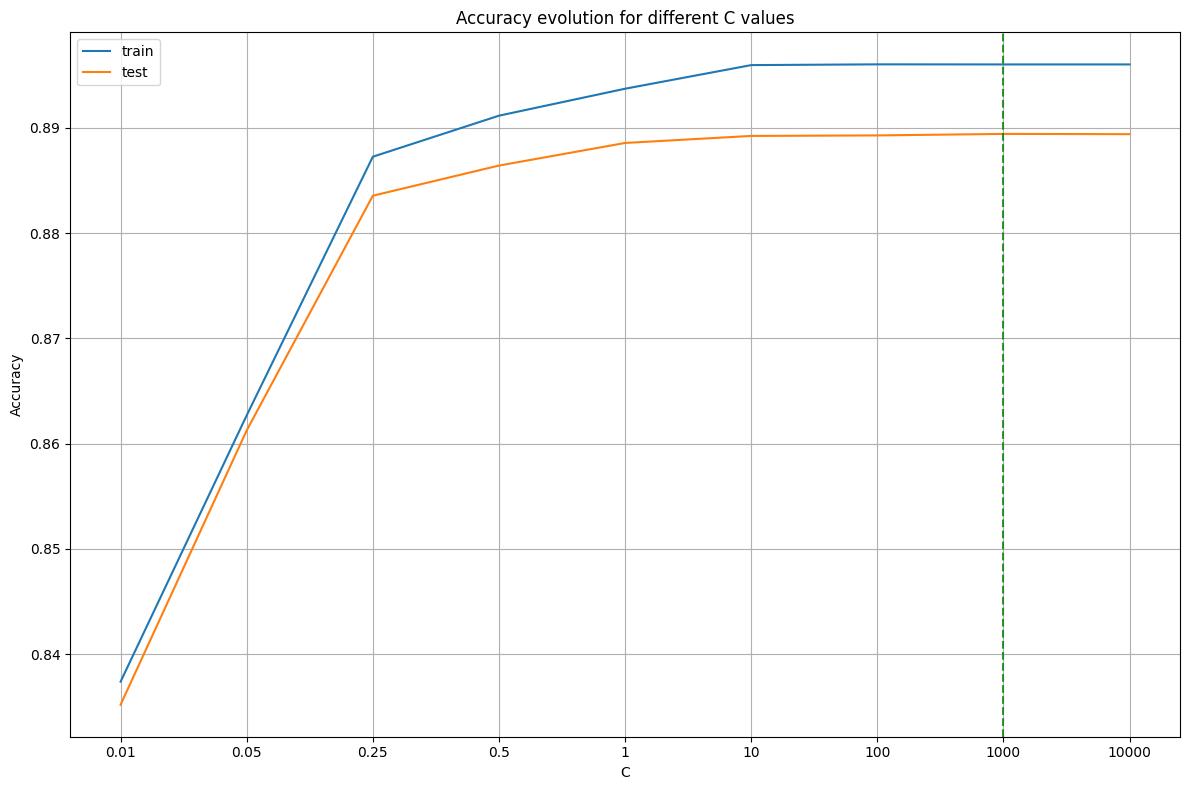

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(train_acc, label='train')
plt.plot(test_acc, label='test')
plt.axvline(np.argmax(test_acc), c='g', ls='--', alpha=0.8)
plt.title('Accuracy evolution for different C values')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.xticks(list(range(len(c_params))), c_params)
plt.tight_layout()
plt.show()

Visto el gráfico parece que el modelo generaliza razonablemente bien. Probablemente con una "C" de entre 1 y 10, el modelo ya obtiene buenos resultados sin incurrir en problemas de overfitting.

MODELO II. MODELO BASADO EN DEEPLEARNING

Vamos a predecir el modelo sobre el mismo bag of words. Utilizaremos un modelo de deeplearning para ello.

In [ ]:


# Define the model
model = Sequential()
model.add(Dense(100, input_dim=X_train_.shape[1], activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # Binary classification

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Convertir los datos dispersos a un formato denso
X_train_dense = X_train_.toarray()
X_test_dense = X_test_.toarray()

# Definir el tamaño del batch size y el numero de epochs
batch_size=64
num_epochs=10
# Reservar para validation una parte de la muestra
X_valid, y_valid = X_train_dense[:batch_size], y_train[:batch_size]  # first batch_size samples
X_train2, y_train2 = X_train_dense[batch_size:], y_train[batch_size:]  # rest for training

# Entrenar el modelo
model.fit(X_train2, y_train2,
          validation_data=(X_valid, y_valid),
          batch_size=batch_size, epochs=num_epochs)

# Evaluar el modelo
_, accuracy = model.evaluate(X_test_dense, y_test)
print('Accuracy: %.2f' % (accuracy*100))

Epoch 1/10
1964/1964 [==============================] - 17s 8ms/step - loss: 0.2917 - accuracy: 0.8786 - val_loss: 0.1862 - val_accuracy: 0.9375
Epoch 2/10
1964/1964 [==============================] - 15s 8ms/step - loss: 0.2541 - accuracy: 0.8958 - val_loss: 0.1651 - val_accuracy: 0.9375
Epoch 3/10
1964/1964 [==============================] - 16s 8ms/step - loss: 0.2193 - accuracy: 0.9140 - val_loss: 0.1597 - val_accuracy: 0.9531
Epoch 4/10
1964/1964 [==============================] - 20s 10ms/step - loss: 0.1565 - accuracy: 0.9439 - val_loss: 0.1962 - val_accuracy: 0.9062
Epoch 5/10
1964/1964 [==============================] - 19s 9ms/step - loss: 0.0911 - accuracy: 0.9703 - val_loss: 0.3121 - val_accuracy: 0.9062
Epoch 6/10
1964/1964 [==============================] - 19s 10ms/step - loss: 0.0454 - accuracy: 0.9861 - val_loss: 0.4218 - val_accuracy: 0.9062
Epoch 7/10
1964/1964 [==============================] - 17s 9ms/step - loss: 0.0247 - accuracy: 0.9926 - val_loss: 0.4693 - val_

In [ ]:
# Predecir las probabilidades de clase para los datos de prueba
y_pred_prob = model.predict(X_test_dense)

# Convertir las probabilidades en clases utilizando un umbral (por ejemplo, 0.5)
y_pred = (y_pred_prob > 0.5).astype(int)

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Calcular el informe de clasificación
class_report = classification_report(y_test, y_pred)
print("\nClassification Report:")
print(class_report)

# Calcular la puntuación de precisión
accuracy = accuracy_score(y_test, y_pred)
print("\nAccuracy Score:", accuracy)


1310/1310 [==============================] - 7s 5ms/step
Confusion Matrix:
[[ 3770  3139]
 [ 2401 32590]]

Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.55      0.58      6909
           1       0.91      0.93      0.92     34991

    accuracy                           0.87     41900
   macro avg       0.76      0.74      0.75     41900
weighted avg       0.86      0.87      0.86     41900


Accuracy Score: 0.867780429594272


Los resultados del modelo son muy similares al modelo anterior, sin que se aprecie significativamente una mejoría de resultados aplicando el modelo de deeplearning. De hecho, ambos modelos fallan en la clasificación de aquellos "reviews" con sentimiento negativo, adoleciendo un problema de muestras desbalanceadas.